# Training GCN AE on Full Data

In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import GraphAE
from parameters import GraphAEParameters, TrainingParameters
from datautils import get_morning_data, get_gcnae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Time Series Sequencing

In [2]:
def sequence_gcnae(data, timesteps, hide_anomalies=True):
    sequence = []
    static_edges = generate_edges(milemarkers=list(range(49)))
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times)):
        data_t = []
        contains_anomaly = np.any([np.unique(data[data['unix_time']==t]['anomaly'])[0]])

        if (hide_anomalies and contains_anomaly):
            continue
        
        kept_indices.append(index)

        data_t.append(data[data['unix_time']==t][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not
        
        curr_data = data_t[-1]
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append(curr_graph)

    return sequence, kept_indices

### Loading Hyperparameters

In [3]:
#optimal_hyperparams = load_best_parameters('gcn_new')

#optimal_hyperparams

In [4]:
study_name = 'gcn_auc_new'

study = optuna.study.load_study(
        study_name=study_name,  # Replace with your study name
        storage=f"sqlite:///studies/{study_name}.db"  # Replace with the path to your SQLite database
)

In [40]:
study_name = 'gcn_v2'

study2 = optuna.study.load_study(
        study_name=study_name,  # Replace with your study name
        storage=f"sqlite:///studies/{study_name}.db"  # Replace with the path to your SQLite database
)

In [5]:
optimal_hyperparams = sorted([trial for trial in study.trials if trial.value is not None], key = lambda x: x.values[0], reverse = True)[0].params

optimal_hyperparams

{'learning_rate': 0.0014332841210632197,
 'timesteps': 4,
 'epochs': 2,
 'latent_dim': 128,
 'gcn_hidden_dim': 128,
 'dropout': 0.1152867039703104,
 'num_gcn': 4,
 'mask_prob': 0.28942060853910284}

In [6]:
mse_weights = [0.1, 0.8, 0.1] # weights for loss function (occupancy, speed, volume)

In [7]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    timesteps=optimal_hyperparams['timesteps'],
    batch_size=1,
    n_epochs=optimal_hyperparams['epochs']
)

In [8]:
import os

train_path, test_path = '../data/train_data.csv', '../data/test_data.csv'

if os.path.exists(train_path) and os.path.exists(test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
else:
    train_data, test_data, _ = get_full_data()
    train_data = normalize_data(train_data)
    train_data = label_anomalies(train_data)

    train_data.to_csv(train_path)
    test_data.to_csv(test_path)

train_sequence, kept_train_indices = sequence_gcnae(train_data, training_params.timesteps)

100%|██████████| 13440/13440 [01:20<00:00, 167.53it/s]


In [9]:
hyperparams = GraphAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_gcn=optimal_hyperparams['num_gcn'],
    mask_prob=optimal_hyperparams['mask_prob']
)

In [10]:
ae = GraphAE(hyperparams)

ae(train_sequence[0]).shape

torch.Size([196, 3])

### Model Training or Loading

In [11]:
using_pretrained = False

if not using_pretrained:
    ae, losses = train_gcnae(gcnaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, 'gcn_newest')
else:
    ae = load_model(GraphAE, hyperparams, 'gcn')

 50%|█████     | 1/2 [02:18<02:18, 138.93s/it]

Epoch number 1 loss: 0.009291595921604539


100%|██████████| 2/2 [04:07<00:00, 123.97s/it]

Epoch number 2 loss: 0.0058137296146286025


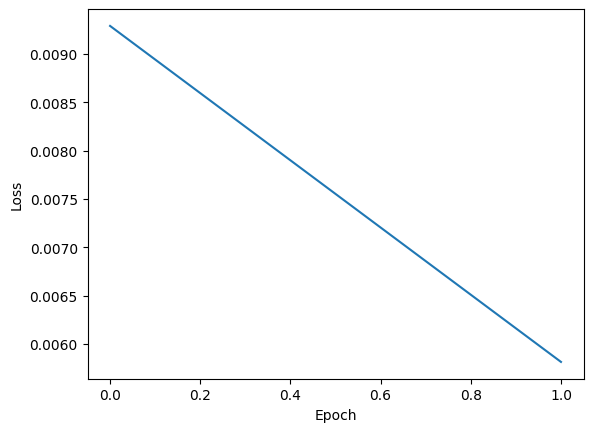

In [12]:
if not using_pretrained:
    plt.plot(losses)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

### Computing Node-level Anomaly Threshold

In [13]:
thresh = compute_anomaly_threshold_gcnae(train_sequence, ae, mse_weights, 'max')

100%|██████████| 6436/6436 [00:43<00:00, 147.44it/s]


### Loading Test Data

In [14]:
_, df_test_data, _ = get_full_data()

In [15]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gcnae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4800/4800 [00:19<00:00, 248.09it/s]


In [16]:
test_errors, test_recons_speeds, test_true_speeds = test_gcnae(test_data, mse_weights, ae)

In [17]:
np.mean(test_errors)

np.float32(0.008902799)

In [22]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

In [24]:
df_test_data

,day,milemarker,human_label,crash_record,unix_time,speed,occ,volume
329280,10,53.3,0,0,1697014800,78.279635,2.0,3.0
1270080,10,53.3,0,0,1697014800,70.838259,1.0,1.0
2210880,10,53.3,0,0,1697014800,67.747571,0.0,0.0
3151680,10,53.3,0,0,1697014800,68.591755,1.0,1.0
329281,10,53.6,0,0,1697014800,76.386234,2.0,3.0
...,...,...,...,...,...,...,...,...
3716158,25,69.8,0,0,1698339570,67.843678,1.0,2.0
893759,25,70.1,0,0,1698339570,80.331434,2.0,3.0
1834559,25,70.1,0,0,1698339570,77.301506,4.0,6.0
2775359,25,70.1,0,0,1698339570,70.466144,3.0,2.0


### Compute AUC

In [23]:
calculate_auc(test_errors, anomaly_labels)

0.7170248375502222

### Compute FPR / Crash Detection Delay Tradeoff

In [25]:
def find_delays(thresh, errors, anomaly_labels, crash_reported, changed_sr=False, sr=0.5):
    results = []
    thresholds = np.array(find_thresholds(thresh, errors, anomaly_labels, changed_sr))
    all_fp_indices = np.where(thresholds[:,0] == 1)[0]
    all_fp_index = all_fp_indices[-1] if len(all_fp_indices) > 0 else None

    no_fp_indices = np.where(thresholds[:,0] == 0)[0]
    no_fp_index = no_fp_indices[-1] if len(no_fp_indices) > 0 else None
    val_range = np.linspace(0.01, 0.99, 98)

    if no_fp_index is None:
        # do something here
        pass
    
    anomaly_pred = threshold_anomalies(thresh + thresholds[no_fp_index][1], errors)
    delays, detects = crash_detection_delay(anomaly_pred, crash_reported, sr=sr) 
    results.append([0, np.mean(delays), np.std(delays), np.sum(detects)/12])

    for i in tqdm(val_range):
        # offset_index = np.abs(thresholds[:,0] - i).argmin()
        offset_index = thresholds.shape[0] - 1 - np.argmin(np.abs(thresholds[:,0][::-1] - i))
        offset = thresholds[offset_index,1]
        anomaly_pred = threshold_anomalies(thresh+offset, errors)
        delays, detects = crash_detection_delay(anomaly_pred, crash_reported, sr=sr) 
        if np.sum(detects) == 0:
            delays = [15/sr]
        results.append([thresholds[offset_index,0], np.mean(delays), np.std(delays), np.sum(detects)/12])
        
    anomaly_pred = threshold_anomalies(thresh+thresholds[all_fp_index][1], errors)
    delays, detects = crash_detection_delay(anomaly_pred, crash_reported, sr=sr) 
    results.append([1, np.mean(delays), np.std(delays), np.sum(detects)/12])

    return results

In [26]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 1000/1000 [01:26<00:00, 11.55it/s]
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/noahschulhof/.conda/envs/pytorch_cpu/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encounter

In [27]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/gcnae_fp_delay.csv')

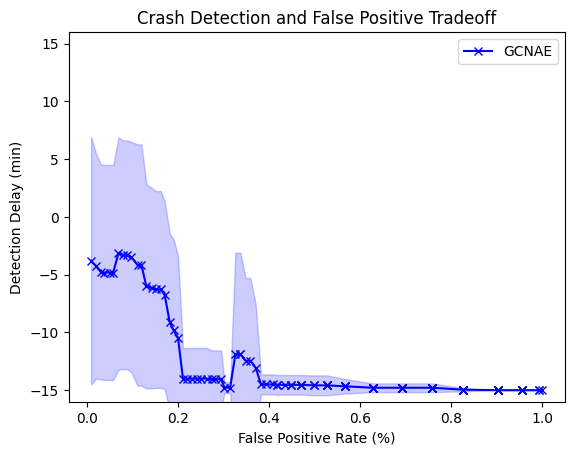

In [28]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='GCNAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [29]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


Found FPR of 0.009799918334013884 for 0.01
Found FPR of 0.02449979583503471 for 0.025
Found FPR of 0.0518579011841568 for 0.05
Found FPR of 0.09840751327072274 for 0.1
Found FPR of 0.2000816659861168 for 0.2
FPR 1% gives mean delay of -3.7857142857142856 +/- 10.733316432149621 while missing 0.41666666666666663%.
FPR 2.5% gives mean delay of -4.3125 +/- 9.759410522669901 while missing 0.33333333333333337%.
FPR 5% gives mean delay of -4.8125 +/- 9.31375830425076 while missing 0.33333333333333337%.
FPR 10% gives mean delay of -3.5 +/- 9.983319421247959 while missing 0.25%.
FPR 20% gives mean delay of -10.5 +/- 7.086763875156433 while missing 0.25%.


### Compute Detection Delay Histogram on Full Dataset

In [30]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [31]:
full_sequence, kept_full_indices = sequence_gcnae(full_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 18240/18240 [02:29<00:00, 122.05it/s]


In [32]:
full_errors, _, _ = test_gcnae(full_sequence, mse_weights, ae)

In [33]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

In [34]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [04:30<00:00,  3.70it/s]


In [35]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)

Found FPR of 0.0997223507635354 for 0.1


In [38]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

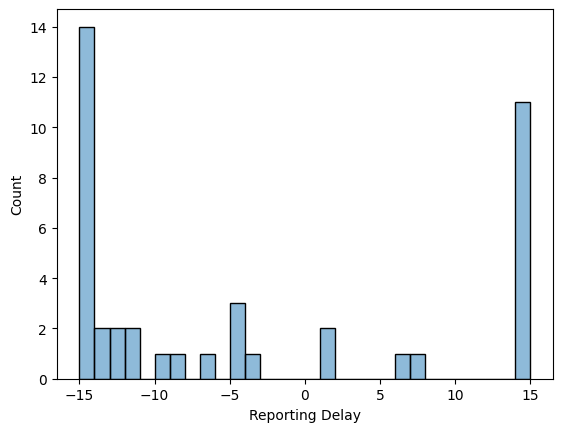

In [39]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='gcnae')

plt.xlabel('Reporting Delay')

plt.show()

In [ ]:
np.save('./saved_results/gcnae10delays.npy', np.array(delay)/2)

In [ ]:
_, df_clean_test_data, _ = get_full_data()

In [ ]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_gcnae(clean_test_data, training_params.timesteps, hide_anomalies=True)

100%|██████████| 4800/4800 [00:12<00:00, 378.83it/s]


In [ ]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_gcnae(clean_test_data, mse_weights, ae)

In [ ]:
np.mean(clean_test_errors)

np.float32(0.009513098)

### Computing AUC on the best models (MSE loss) from the masking experiment

In [ ]:
study_name = 'gcn_mask'

study = optuna.study.load_study(
        study_name=study_name,  # Replace with your study name
        storage=f"sqlite:///studies/{study_name}.db"  # Replace with the path to your SQLite database
)

In [ ]:
# trials = [trial for trial in study.trials if trial.values is not None]

# trials = sorted(trials, key = lambda x: x.values[0])

# top_params = [trial.params for trial in trials[:10]]

# models = []
# aucs = []

# for param in top_params:
#     training_params = TrainingParameters(
#         learning_rate=param['learning_rate'],
#         timesteps=param['timesteps'],
#         batch_size=1,
#         n_epochs=param['epochs']
#     )
    
#     hyperparams = GraphAEParameters(
#         num_features=3,
#         latent_dim=param['latent_dim'],
#         gcn_hidden_dim=param['gcn_hidden_dim'],
#         dropout=param['dropout'],
#         num_gcn=param['num_gcn']
#     )
#     ae, losses = train_gcnae(gcnaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)

#     models.append(ae)

#     test_errors, test_recons_speeds, test_true_speeds = test_gcnae(test_data, mse_weights, ae)

#     aucs.append(calculate_auc(test_errors, anomaly_labels))

 20%|██        | 1/5 [01:18<05:14, 78.73s/it]

Epoch number 1 loss: 0.010137988530543492


 40%|████      | 2/5 [02:33<03:48, 76.16s/it]

Epoch number 2 loss: 0.005648680564682905


 60%|██████    | 3/5 [03:54<02:36, 78.39s/it]

Epoch number 3 loss: 0.0054755842032008254


 80%|████████  | 4/5 [05:03<01:14, 74.95s/it]

Epoch number 4 loss: 0.005815838126775999


100%|██████████| 5/5 [06:11<00:00, 74.22s/it]

Epoch number 5 loss: 0.005484149223368619



 25%|██▌       | 1/4 [00:53<02:39, 53.11s/it]

Epoch number 1 loss: 0.006588815651783943


 50%|█████     | 2/4 [01:49<01:49, 54.93s/it]

Epoch number 2 loss: 0.005895738789049568


 75%|███████▌  | 3/4 [02:43<00:54, 54.40s/it]

Epoch number 3 loss: 0.0054833042723166645


100%|██████████| 4/4 [03:37<00:00, 54.37s/it]

Epoch number 4 loss: 0.0055663923616647674



 20%|██        | 1/5 [00:52<03:28, 52.19s/it]

Epoch number 1 loss: 0.00669378237049418


 40%|████      | 2/5 [01:45<02:39, 53.12s/it]

Epoch number 2 loss: 0.08194545810924472


 60%|██████    | 3/5 [02:39<01:47, 53.53s/it]

Epoch number 3 loss: 0.007748068204938826


 80%|████████  | 4/5 [03:51<01:00, 60.48s/it]

Epoch number 4 loss: 0.009844192139440575


100%|██████████| 5/5 [05:51<00:00, 70.22s/it]

Epoch number 5 loss: 0.007973676690313519



 20%|██        | 1/5 [01:55<07:42, 115.71s/it]

Epoch number 1 loss: 0.0066039788908909165


 40%|████      | 2/5 [03:14<04:41, 93.81s/it] 

Epoch number 2 loss: 0.005580632539036321


 60%|██████    | 3/5 [04:40<03:00, 90.48s/it]

Epoch number 3 loss: 0.0056098700041350615


 80%|████████  | 4/5 [05:59<01:25, 85.76s/it]

Epoch number 4 loss: 0.00547981483945118


100%|██████████| 5/5 [07:20<00:00, 88.19s/it]

Epoch number 5 loss: 0.005439057174980764



 20%|██        | 1/5 [00:51<03:25, 51.43s/it]

Epoch number 1 loss: 0.007108297057742412


 40%|████      | 2/5 [01:45<02:39, 53.12s/it]

Epoch number 2 loss: 0.005662919135591753


 60%|██████    | 3/5 [02:36<01:44, 52.13s/it]

Epoch number 3 loss: 0.0054965297935044765


 80%|████████  | 4/5 [03:26<00:51, 51.19s/it]

Epoch number 4 loss: 0.0054167234432335705


100%|██████████| 5/5 [04:21<00:00, 52.31s/it]

Epoch number 5 loss: 0.005373806711715719



 25%|██▌       | 1/4 [00:52<02:38, 52.92s/it]

Epoch number 1 loss: 0.006594738500917228


 50%|█████     | 2/4 [01:44<01:44, 52.37s/it]

Epoch number 2 loss: 0.0055584270491396736


 75%|███████▌  | 3/4 [02:39<00:53, 53.41s/it]

Epoch number 3 loss: 0.005469613115752817


100%|██████████| 4/4 [03:32<00:00, 53.09s/it]

Epoch number 4 loss: 0.005497642437094068



 20%|██        | 1/5 [00:48<03:13, 48.35s/it]

Epoch number 1 loss: 0.006219297224846614


 40%|████      | 2/5 [01:37<02:26, 48.80s/it]

Epoch number 2 loss: 0.005649263839885093


 60%|██████    | 3/5 [02:25<01:37, 48.55s/it]

Epoch number 3 loss: 0.005505169672613157


 80%|████████  | 4/5 [03:18<00:50, 50.23s/it]

Epoch number 4 loss: 0.00544349530772293


100%|██████████| 5/5 [04:10<00:00, 50.17s/it]

Epoch number 5 loss: 0.0054163700342807816



 20%|██        | 1/5 [00:53<03:32, 53.20s/it]

Epoch number 1 loss: 0.00836096779659875


 40%|████      | 2/5 [01:45<02:37, 52.54s/it]

Epoch number 2 loss: 0.005925006665245412


 60%|██████    | 3/5 [02:37<01:45, 52.62s/it]

Epoch number 3 loss: 0.01918516381574037


 80%|████████  | 4/5 [03:30<00:52, 52.64s/it]

Epoch number 4 loss: 0.0055186795454507465


100%|██████████| 5/5 [04:25<00:00, 53.11s/it]

Epoch number 5 loss: 0.009337626183735447



 25%|██▌       | 1/4 [00:36<01:49, 36.56s/it]

Epoch number 1 loss: 0.005973811960580378


 50%|█████     | 2/4 [01:13<01:13, 36.90s/it]

Epoch number 2 loss: 0.005515845949904321


 75%|███████▌  | 3/4 [01:49<00:36, 36.50s/it]

Epoch number 3 loss: 0.005458690338703888


100%|██████████| 4/4 [02:25<00:00, 36.36s/it]

Epoch number 4 loss: 0.0054742316947218915



 25%|██▌       | 1/4 [01:01<03:05, 61.97s/it]

Epoch number 1 loss: 0.0065085279857022066


 50%|█████     | 2/4 [02:05<02:06, 63.18s/it]

Epoch number 2 loss: 0.005779173849115086


 75%|███████▌  | 3/4 [03:08<01:02, 62.75s/it]

Epoch number 3 loss: 0.0056602699102246655


100%|██████████| 4/4 [04:11<00:00, 62.95s/it]

Epoch number 4 loss: 0.005571272931145036


### AUC experiment

In [ ]:
study_name = 'gcn_auc'

study = optuna.study.load_study(
        study_name=study_name,  # Replace with your study name
        storage=f"sqlite:///studies/{study_name}.db"  # Replace with the path to your SQLite database
)

In [ ]:
study.trials_dataframe().sort_values('value', ascending = False)

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_epochs,params_gcn_hidden_dim,params_latent_dim,params_learning_rate,params_mask_prob,params_num_gcn,params_timesteps,state
6,6,0.772330,2025-10-22 00:52:59.315255,2025-10-22 00:59:52.802288,0 days 00:06:53.487033,0.337528,3,128,64,0.000003,0.278612,3,3,COMPLETE
12,12,0.751008,2025-10-22 01:04:09.076771,2025-10-22 01:13:04.107287,0 days 00:08:55.030516,0.140811,4,32,64,0.000383,0.222946,3,2,COMPLETE
4,4,0.750582,2025-10-22 00:48:20.585039,2025-10-22 01:01:34.018089,0 days 00:13:13.433050,0.471133,4,64,64,0.000019,0.374115,5,5,COMPLETE
36,36,0.750164,2025-10-22 01:30:43.131294,2025-10-22 01:34:51.066630,0 days 00:04:07.935336,0.029550,2,16,128,0.000009,0.294866,1,5,COMPLETE
80,80,0.746438,2025-10-22 02:30:30.940743,2025-10-22 02:37:15.222649,0 days 00:06:44.281906,0.048069,1,32,128,0.000006,0.133371,5,4,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,26,0.362231,2025-10-22 01:21:22.026175,2025-10-22 01:24:25.992228,0 days 00:03:03.966053,0.296859,1,16,128,0.000002,0.158993,1,4,COMPLETE
84,84,0.349921,2025-10-22 02:37:15.296563,2025-10-22 02:40:19.425856,0 days 00:03:04.129293,0.242130,1,16,128,0.000001,0.101003,1,4,COMPLETE
82,82,0.319204,2025-10-22 02:34:34.879612,2025-10-22 02:41:14.491290,0 days 00:06:39.611678,0.046586,1,16,128,0.000003,0.123484,5,5,COMPLETE
54,54,0.312836,2025-10-22 01:56:59.364986,2025-10-22 01:59:53.116047,0 days 00:02:53.751061,0.276694,1,16,128,0.000002,0.104118,2,4,COMPLETE


In [ ]:
sorted(study.trials, key = lambda x: x.values[0], reverse = True)[:5]

[FrozenTrial(number=6, state=1, values=[0.772329597870635], datetime_start=datetime.datetime(2025, 10, 22, 0, 52, 59, 315255), datetime_complete=datetime.datetime(2025, 10, 22, 0, 59, 52, 802288), params={'learning_rate': 3.2003009201736143e-06, 'timesteps': 3, 'epochs': 3, 'latent_dim': 64, 'gcn_hidden_dim': 128, 'dropout': 0.3375283234668684, 'num_gcn': 3, 'mask_prob': 0.2786116685406589}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-06, step=None), 'timesteps': IntDistribution(high=5, log=False, low=2, step=1), 'epochs': IntDistribution(high=5, log=False, low=1, step=1), 'latent_dim': CategoricalDistribution(choices=(32, 64, 128)), 'gcn_hidden_dim': CategoricalDistribution(choices=(16, 32, 64, 128)), 'dropout': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'num_gcn': IntDistribution(high=5, log=False, low=1, step=1), 'mask_prob': FloatDistribution(high=0.4, log=False, low=0.1, step

In [134]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [ ]:
# data.to_csv('./saved_results/full_results_test_rstae.csv')

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_rstae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [ ]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [ ]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()